In [1]:
from os import environ
environ["TOKENIZERS_PARALLELISM"] = "false"

import re
from concurrent.futures import ThreadPoolExecutor
from tqdm import tqdm
from json import dumps, loads
from collections import Counter
import numpy as np
import textstat
from transformers import AutoTokenizer
import matplotlib.pyplot as plt

from utils.storage import list_pdf_files, list_mmd_files, list_processed_mmd_files, download_processed_mmd_file, download_file_metadata, download_keywords, download_plain_text

/Users/Matic/Documents/School/Magistrska/Monorepo/components/notebooks/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
tokenizer = AutoTokenizer.from_pretrained('allenai/scibert_scivocab_uncased')

In [3]:
print("Number of scraped PDF files:", len(list_pdf_files()))
print("Number of unprocessed MMD files:", len(list_mmd_files()))

files = list_processed_mmd_files()
print("Number of processed MMD files:", len(files))

Number of scraped PDF files: 77031
Number of unprocessed MMD files: 75816
Number of processed MMD files: 73345


In [4]:
with ThreadPoolExecutor() as executor:
	metadata = list(tqdm(executor.map(download_file_metadata, files), total=len(files)))

with ThreadPoolExecutor() as executor:
	mds = list(tqdm(executor.map(download_processed_mmd_file, files), total=len(files)))

with ThreadPoolExecutor() as executor:
	plain = list(tqdm(executor.map(download_plain_text, files), total=len(files)))

with ThreadPoolExecutor() as executor:
	keywords = list(tqdm(executor.map(download_keywords, files), total=len(files)))

100%|██████████| 73345/73345 [10:00<00:00, 122.14it/s] 


In [5]:
lengths = []
vocabulary = Counter()
for md in tqdm(mds):
	tokenized = tokenizer(md, return_tensors='pt', padding=False, truncation=False)
	lengths.append(tokenized['input_ids'].shape[1])
	vocabulary.update(tokenized['input_ids'].flatten().tolist())

100%|██████████| 73345/73345 [31:44<00:00, 38.50it/s]


Vocabulary size: 26906
Mean length: 13505.02, median length: 12094.00


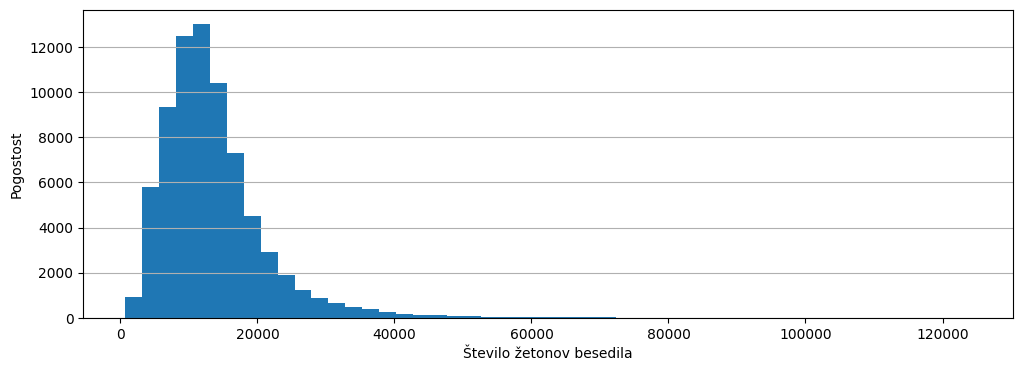

In [6]:
print(f"Vocabulary size: {len(vocabulary)}")
print(f"Mean length: {np.mean(lengths):.2f}, median length: {np.median(lengths):.2f}")

plt.figure(figsize=(12, 4))
plt.hist(lengths, bins=50)
plt.xlabel('Število žetonov besedila')
plt.ylabel('Pogostost')
plt.grid(axis='y')
plt.show()

In [7]:
tasks = Counter(
	task
	for e in metadata
	for task in e["tasks"]
)
methods = Counter(
	method
	for e in metadata
	for method in e["methods"]
)
datasets = Counter(
	dataset
	for e in metadata
	for dataset in e["datasets"]
)
commonKeywords = Counter(
	keyword[0]
	for _keywords in keywords
	for keyword in _keywords
)

In [8]:
missingTasks = 0
missingMethods = 0
missingDatasets = 0
missingResults = 0
for filename, meta in zip(files, metadata):
	if len(meta["tasks"]) == 0:
		missingTasks += 1
	if len(meta["methods"]) == 0:
		missingMethods += 1
	if len(meta["datasets"]) == 0:
		missingDatasets += 1
	if len(meta["results"]) == 0:
		missingResults += 1

print(missingTasks / len(files) * 100, "% of files have no tasks")
print(missingMethods / len(files) * 100, "% of files have no methods")
print(missingDatasets / len(files) * 100, "% of files have no datasets")
print(missingResults / len(files) * 100, "% of files have no results")

0.14452246233553753 % of files have no tasks
61.45204172063535 % of files have no methods
41.56929579385098 % of files have no datasets
83.36491921739724 % of files have no results


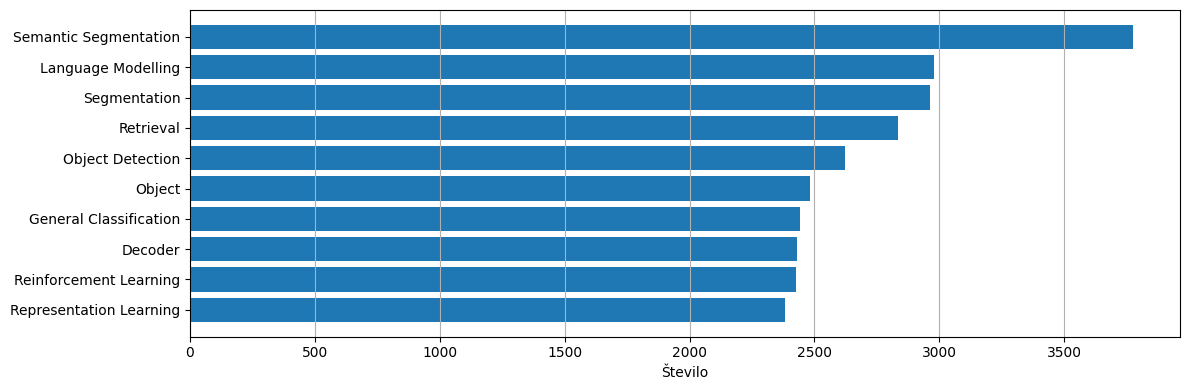

In [9]:
sortedTasks = tasks.most_common(10)
taskNames = [task[0] for task in sortedTasks]
taskCounts = [task[1] for task in sortedTasks]

plt.figure(figsize=(12, 4))
plt.barh(range(len(taskNames)), taskCounts)
plt.yticks(range(len(taskNames)), taskNames)
plt.xlabel('Število')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

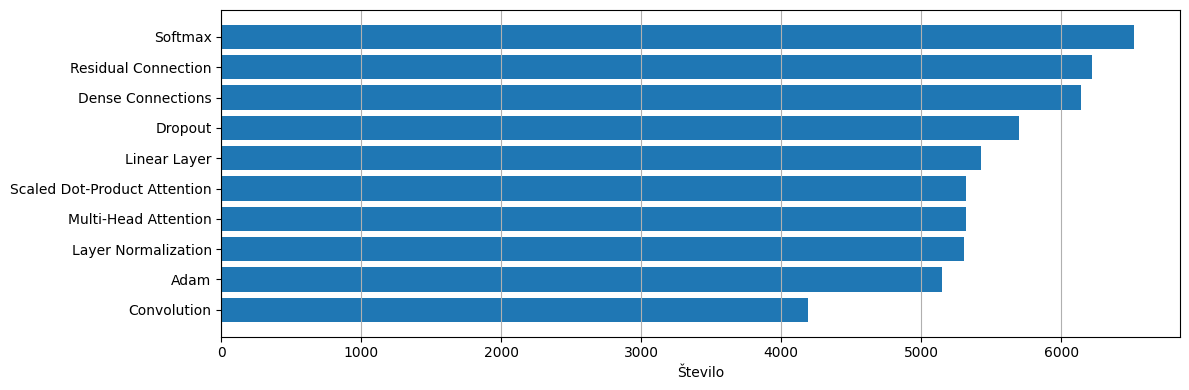

In [10]:
sortedMethods = methods.most_common(10)
methodNames = [method[0] for method in sortedMethods]
methodCounts = [method[1] for method in sortedMethods]

plt.figure(figsize=(12, 4))
plt.barh(range(len(methodNames)), methodCounts)
plt.yticks(range(len(methodNames)), methodNames)
plt.xlabel('Število')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

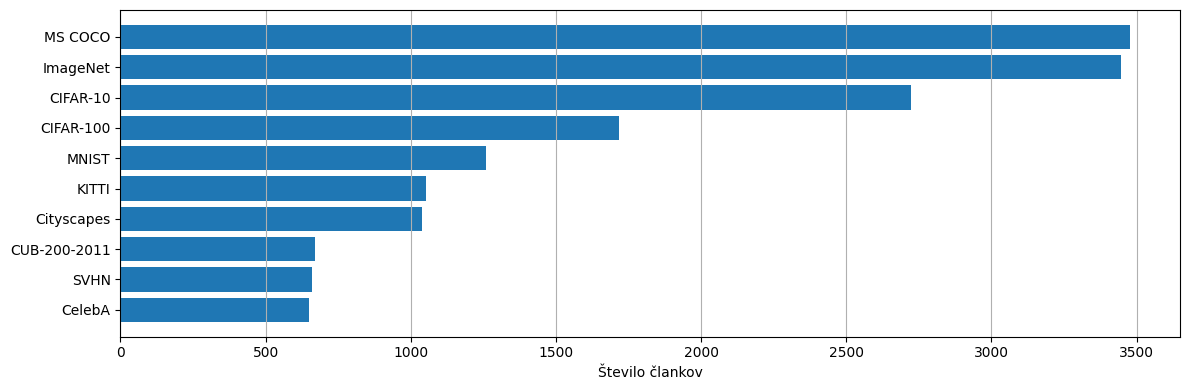

In [11]:
sortedDatasets = datasets.most_common(10)
datasetNames = [dataset[0] for dataset in sortedDatasets]
datasetCounts = [dataset[1] for dataset in sortedDatasets]

plt.figure(figsize=(12, 4))
plt.barh(range(len(datasetNames)), datasetCounts)
plt.yticks(range(len(datasetNames)), datasetNames)
plt.xlabel('Število člankov')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

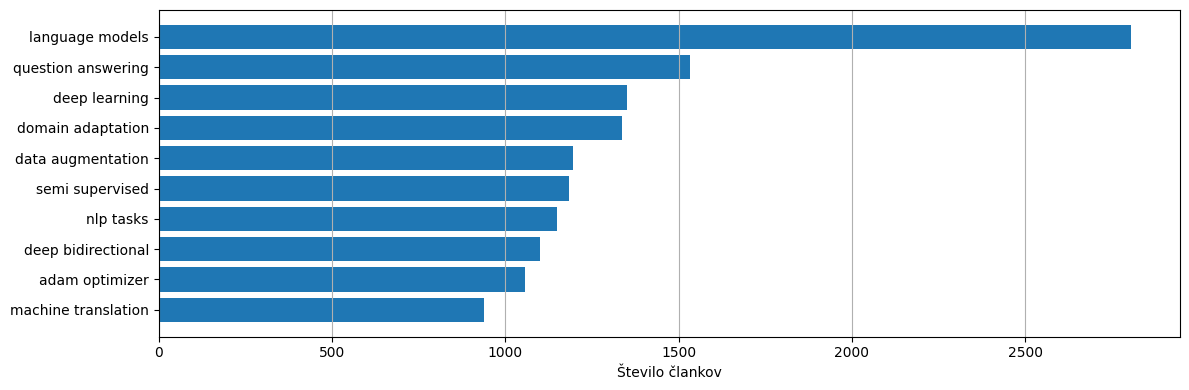

In [12]:
sortedKeywords = commonKeywords.most_common(10)
keywordNames = [keyword[0] for keyword in sortedKeywords]
keywordCounts = [keyword[1] for keyword in sortedKeywords]

plt.figure(figsize=(12, 4))
plt.barh(range(len(keywordNames)), keywordCounts)
plt.yticks(range(len(keywordNames)), keywordNames)
plt.xlabel('Število člankov')
plt.gca().invert_yaxis()
plt.grid(axis='x')
plt.tight_layout()
plt.show()

100%|██████████| 73345/73345 [01:19<00:00, 918.50it/s] 


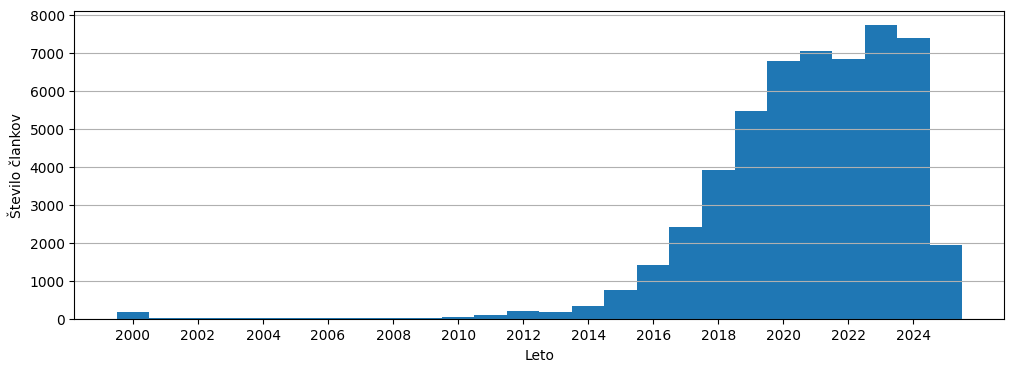

In [13]:
years = []
for md in tqdm(mds):
	year = re.findall(r'\b(20\d{2})\b', md)
	if year:
		maxYear = max(int(y) for y in year)
		years.append(maxYear)

plt.figure(figsize=(12, 4))
plt.hist(years, bins=range(2000, 2027), align='left')
plt.xlabel('Leto')
plt.ylabel('Število člankov')
plt.xticks(range(2000, 2026, 2))
plt.grid(axis='y')
plt.show()

100%|██████████| 73345/73345 [11:34<00:00, 105.55it/s] 


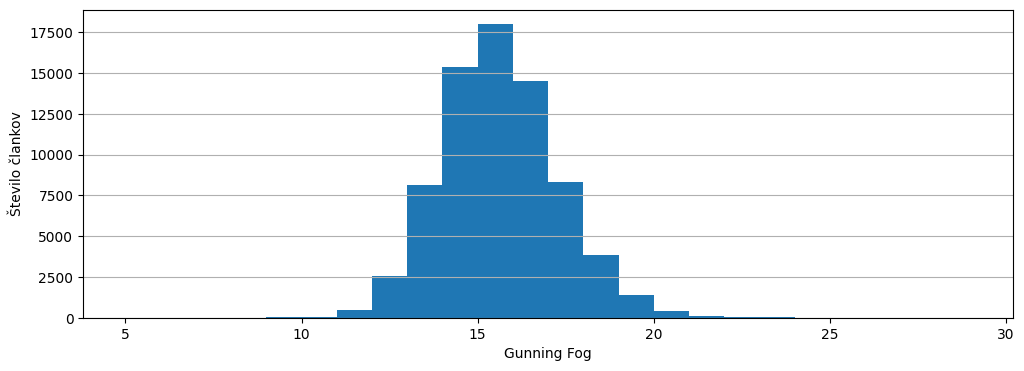

In [14]:
def calculate_gunning_fog(text: str) -> float:
    return textstat.gunning_fog(text)

gunningStats = []
for text in tqdm(plain):
	gunningStats.append(calculate_gunning_fog(text))

plt.figure(figsize=(12, 4))
plt.hist(gunningStats, bins=range(5, 30))
plt.xlabel('Gunning Fog')
plt.ylabel('Število člankov')
plt.grid(axis='y')
plt.show()